# Bibliothèques <a class="anchor" id="prepare"></a>

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16

from keras.utils import Sequence

listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/")

['stage_2_train',
 'stage_2_sample_submission.csv',
 'stage_2_test',
 'stage_2_train.csv']

In [8]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [9]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"

1. # Analyse exploratoire <a class="anchor" id="explore"></a>

## Sample Submission <a class="anchor" id="sample_submission"></a>

In [10]:
submission = pd.read_csv(INPUT_PATH + "stage_2_sample_submission.csv")
submission.head(10)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5
7,ID_d62ec3412_intraparenchymal,0.5
8,ID_d62ec3412_intraventricular,0.5
9,ID_d62ec3412_subarachnoid,0.5


## Distribution des données cibles  <a class="anchor" id="targets"></a>

In [11]:
traindf = pd.read_csv(INPUT_PATH + "stage_2_train.csv")
traindf.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


# **Arrangement du tableau des données de formation**

In [12]:
label = traindf.Label.values

In [13]:
traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
traindf.head()

,0,1,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [14]:
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
subtype_counts = traindf.groupby("subtype").label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1] / traindf.groupby("subtype").size() * 100

In [15]:
traindf.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


# **Pareil pour les données de test**

In [16]:
testdf = submission.ID.str.rsplit("_", n=1, expand=True)
testdf = testdf.rename({0: "id", 1: "subtype"}, axis=1)
testdf.loc[:, "label"] = 0
testdf.head()

,id,subtype,label
0,ID_0fbf6a978,epidural,0
1,ID_0fbf6a978,intraparenchymal,0
2,ID_0fbf6a978,intraventricular,0
3,ID_0fbf6a978,subarachnoid,0
4,ID_0fbf6a978,subdural,0


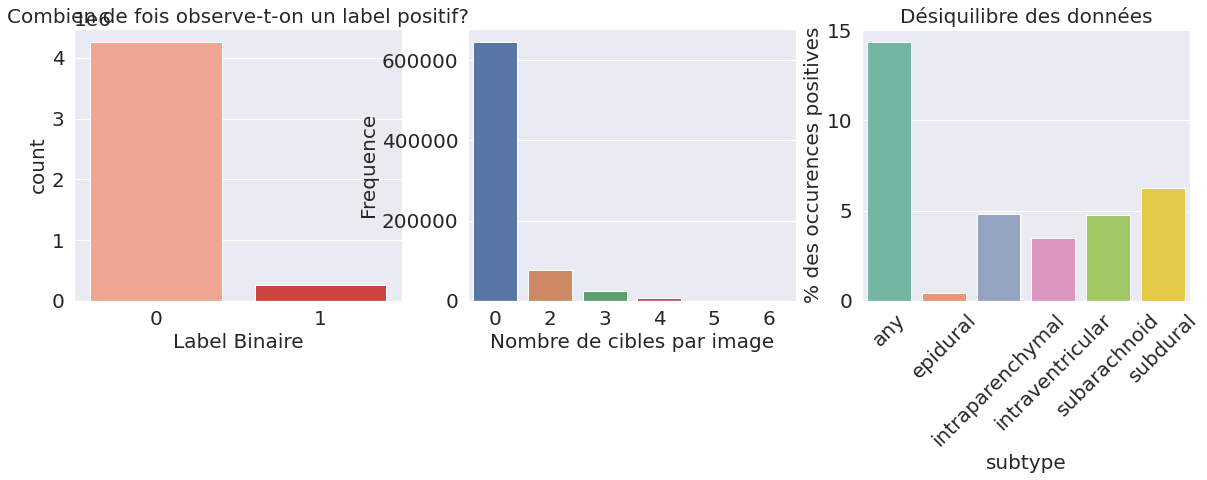

In [17]:
multi_target_count = traindf.groupby("id").label.sum()

fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.countplot(traindf.label, ax=ax[0], palette="Reds")
ax[0].set_xlabel("Label Binaire")
ax[0].set_title("Combien de fois observe-t-on un label positif?");

sns.countplot(multi_target_count, ax=ax[1])
ax[1].set_xlabel("Nombre de cibles par image")
ax[1].set_ylabel("Frequence")


sns.barplot(x=subtype_counts.index, y=subtype_counts.values, ax=ax[2], palette="Set2")
plt.xticks(rotation=45); 
ax[2].set_title("Désiquilibre des données")
ax[2].set_ylabel("% des occurences positives");


In [18]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

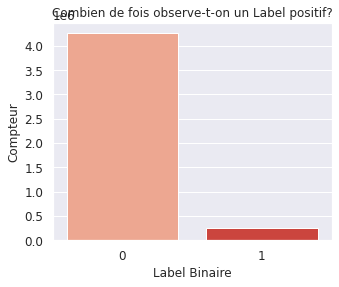

In [19]:
multi_target_count = traindf.groupby("id").label.sum()
fig=plt.figure(figsize=(5, 4))
sns.countplot(traindf.label,palette="Reds")
plt.xlabel("Label Binaire")
plt.ylabel("Compteur")
plt.title("Combien de fois observe-t-on un Label positif?");

In [20]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


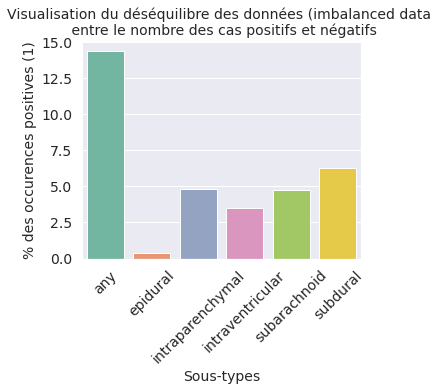

In [21]:
multi_target_count = traindf.groupby("id").label.sum()
fig=plt.figure(figsize=(5, 4))
sns.barplot(x=subtype_counts.index, y=subtype_counts.values,palette="Set2")
plt.xticks(rotation=45); 
plt.title("Visualisation du déséquilibre des données (imbalanced data \n entre le nombre des cas positifs et négatifs")
plt.ylabel("% des occurences positives (1)");
plt.xlabel("Sous-types");

## Nombre des données de formation <a class="anchor" id="num_samples"></a>

In [22]:
traindf.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [23]:
traindf.id.nunique()

752803

# **Vérification avec le nombre d'images disponible **

In [24]:
train_dir = INPUT_PATH + "stage_2_train/"
train_files = listdir(train_dir)

In [25]:
train_size = len(train_files)
train_size

752803

C'est ok

In [26]:
test_dir = INPUT_PATH + "stage_2_test/"
test_files = listdir(test_dir)
test_size = len(test_files)
test_size

121232

In [27]:
train_size/test_size

6.209606374554573

**Prétraitement des fichiers dicom** <a class="anchor" id="dicom"></a>

In [28]:
train_files[0:10]

['ID_b83c56d9b.dcm',
 'ID_ce2c5de36.dcm',
 'ID_a17def68d.dcm',
 'ID_27d79621e.dcm',
 'ID_52ea72f4e.dcm',
 'ID_3e6f24281.dcm',
 'ID_2ac27330f.dcm',
 'ID_f94d60ae5.dcm',
 'ID_6cca7c8f5.dcm',
 'ID_6a45d7732.dcm']


Le nom de fichier est donné par la colonne * ID_alphanum. Avec str.rsplit de pandas, nous  pouvons facilement charger les images étant donné la colonne id

In [29]:
subtypes = traindf.subtype.unique()
subtypes

array(['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
       'subdural', 'any'], dtype=object)

## Les informations contenues dans un fichier Dicom<a class="anchor" id="dicomfile"></a>

In [30]:
dataset = pydicom.dcmread(train_dir + "ID_c5c23af94.dcm")
print(dataset)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.287479881353235692406245215204448333795
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_c5c23af94
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_9630cc49'
(0020, 000d) Study Instance UID                  UI: ID_c5409f3ace
(0020, 000e) Series Instance UID                 UI: ID_5db30227b2
(0020, 0010) Study ID                            SH: ''
(0020, 00

## Distribution des pixels dans les images pour redimensionnement et fenetrage <a class="anchor" id="pixelarray"></a>



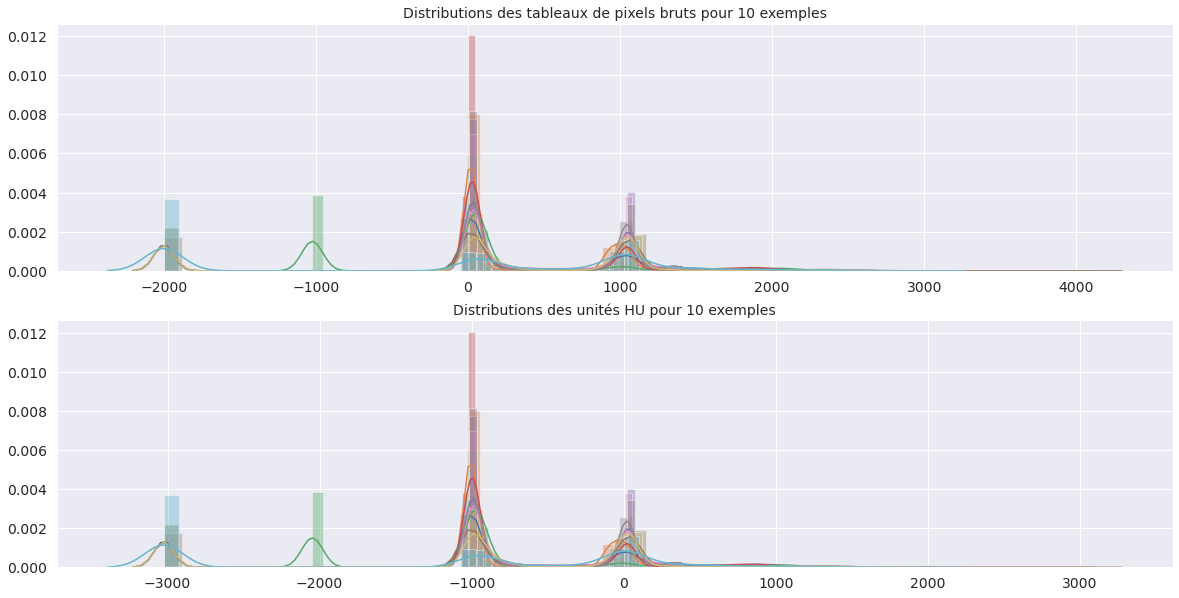

In [31]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
for file in train_files[0:10]:
    dataset = pydicom.dcmread(train_dir + file)
    image = dataset.pixel_array.flatten()
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Distributions des tableaux de pixels bruts pour 10 exemples")
ax[1].set_title("Distributions des unités HU pour 10 exemples");

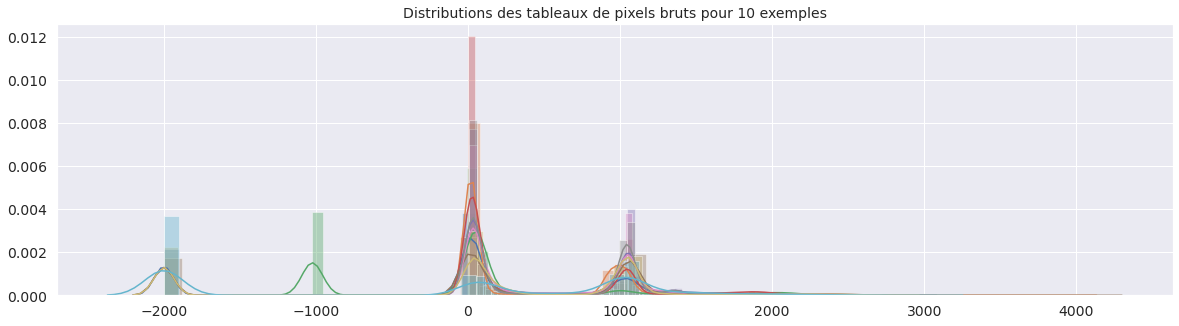

In [32]:
fig = plt.figure(figsize=(20,5))
for file in train_files[0:10]:
    dataset = pydicom.dcmread(train_dir + file)
    image = dataset.pixel_array.flatten()
    sns.distplot(image.flatten());
plt.title("Distributions des tableaux de pixels bruts pour 10 exemples");


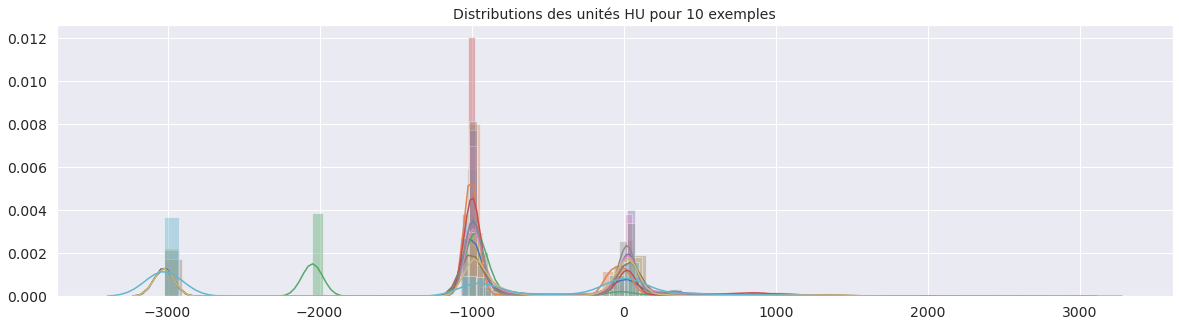

In [33]:
fig = plt.figure(figsize=(20,5))
for file in train_files[0:10]:
    dataset = pydicom.dcmread(train_dir + file)
    image = dataset.pixel_array.flatten()
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    sns.distplot(rescaled_image.flatten())
plt.title("Distributions des unités HU pour 10 exemples");


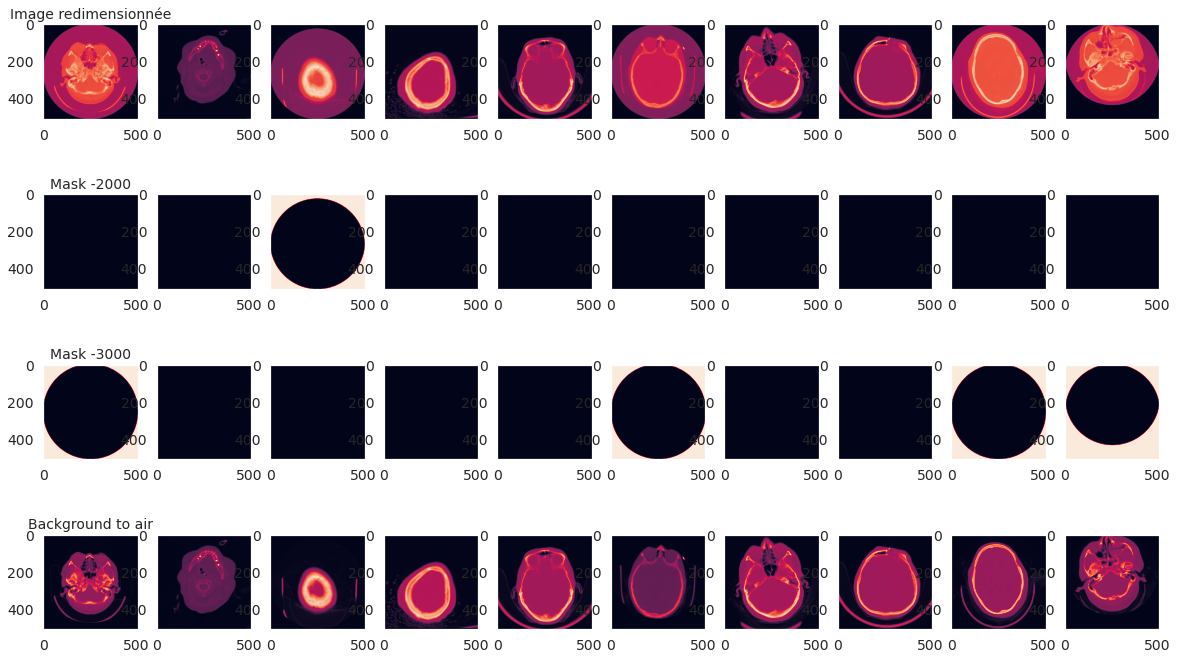

In [34]:
fig, ax = plt.subplots(4,10,figsize=(20,12))

for n in range(10):
    dataset = pydicom.dcmread(train_dir + train_files[n])
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    mask2000 = np.where((rescaled_image <= -1500) & (rescaled_image > -2500), 1, 0)
    mask3000 = np.where(rescaled_image <= -2500, 1, 0)
    ax[0,n].imshow(rescaled_image)
    #ax[0,n].imshow(image)
    rescaled_image[rescaled_image < -1024] = -1024
    ax[1,n].imshow(mask2000)
    ax[2,n].imshow(mask3000)
    ax[3,n].imshow(rescaled_image)
    ax[0,n].grid(False)
    ax[1,n].grid(False)
    ax[2,n].grid(False)
    ax[3,n].grid(False)
ax[0,0].set_title("Image redimensionnée")
ax[1,0].set_title("Mask -2000")
ax[2,0].set_title("Mask -3000");
ax[3,0].set_title("Background to air");

In [35]:
SMALL_SIZE = 14
MEDIUM_SIZE = 24
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

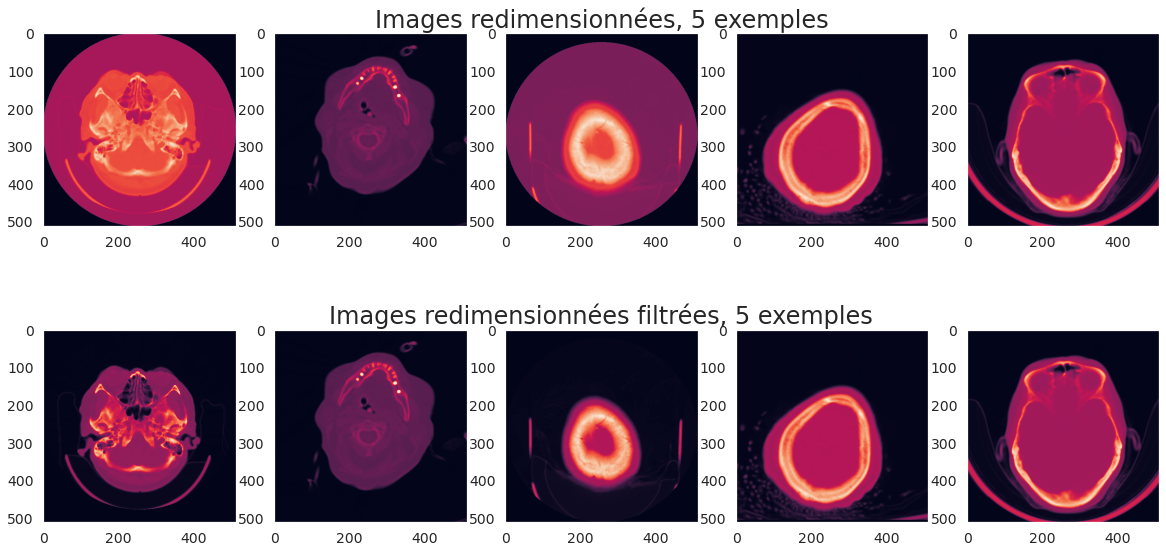

In [36]:
fig, ax = plt.subplots(2,5,figsize=(20,10))

for n in range(5):
    dataset = pydicom.dcmread(train_dir + train_files[n])
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    ax[0,n].imshow(rescaled_image)
    rescaled_image[rescaled_image < -1024] = -1024
    ax[1,n].imshow(rescaled_image)
    ax[0,n].grid(False)
    ax[1,n].grid(False)
ax[0,2].set_title("Images redimensionnées, 5 exemples")
ax[1,2].set_title("Images redimensionnées filtrées, 5 exemples");

**Definition fonction rescale**

In [37]:
def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

**Fenetrage**



In [38]:
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

In [39]:
window_widths = []
window_levels = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    win_width = get_window_value(dataset.WindowWidth)
    win_center = get_window_value(dataset.WindowCenter)
    window_widths.append(win_width)
    window_levels.append(win_center)
    spacing_filenames.append(file)

In [40]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

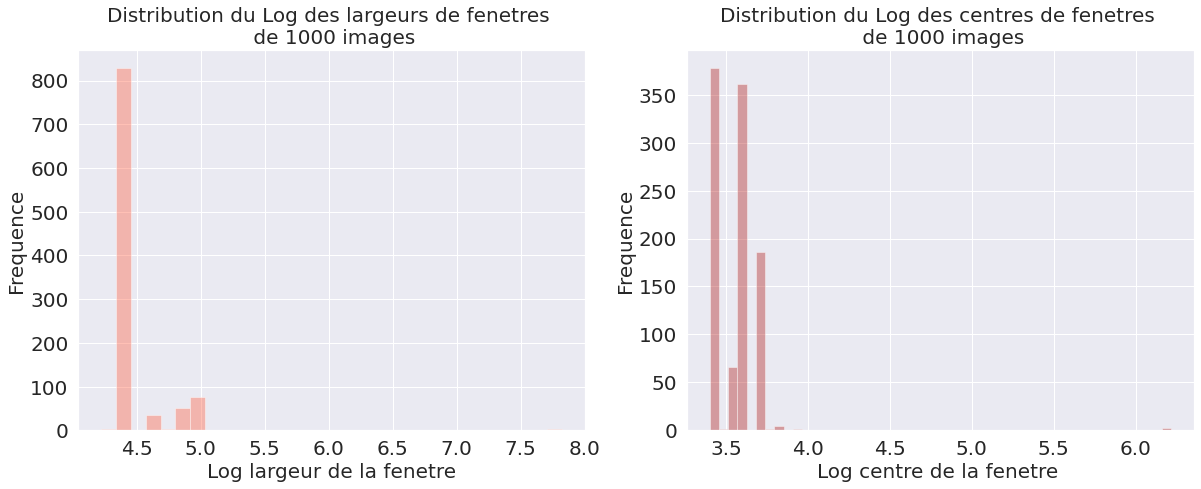

In [41]:
fig, ax = plt.subplots(1,2,figsize=(20,7))


sns.distplot(np.log(window_widths), kde=False, ax=ax[0], color="Tomato")
ax[0].set_title("Distribution du Log des largeurs de fenetres \n de 1000 images")
ax[0].set_xlabel("Log largeur de la fenetre")
ax[0].set_ylabel("Frequence")

sns.distplot(np.log(window_levels), kde=False, ax=ax[1], color="Firebrick")
ax[1].set_title("Distribution du Log des centres de fenetres \n de 1000 images")
ax[1].set_xlabel("Log centre de la fenetre ")
ax[1].set_ylabel("Frequence");

**Choix du centre et de la largeur de notre fenetre**

In [42]:
doc_windows = pd.DataFrame(index=spacing_filenames, columns=["win_width", "win_level"])
doc_windows["win_width"] = window_widths
doc_windows["win_level"] = window_levels
doc_windows.head(20)

,win_width,win_level
ID_b83c56d9b.dcm,80,30
ID_ce2c5de36.dcm,80,36
ID_a17def68d.dcm,100,40
ID_27d79621e.dcm,80,40
ID_52ea72f4e.dcm,80,36
ID_3e6f24281.dcm,80,30
ID_2ac27330f.dcm,80,36
ID_f94d60ae5.dcm,80,36
ID_6cca7c8f5.dcm,80,30
ID_6a45d7732.dcm,80,30


In [43]:
doc_windows[doc_windows.win_width==doc_windows.win_width.median()]

,win_width,win_level
ID_b83c56d9b.dcm,80,30
ID_ce2c5de36.dcm,80,36
ID_27d79621e.dcm,80,40
ID_52ea72f4e.dcm,80,36
ID_3e6f24281.dcm,80,30
...,...,...
ID_f414af134.dcm,80,36
ID_3ad5116cf.dcm,80,36
ID_59c5fafba.dcm,80,36
ID_cba81fde8.dcm,80,40


In [44]:
doc_windows.describe()

,win_width,win_level
count,1000.000000,1000.000000
mean,93.691000,35.401000
std,109.905809,21.168285
min,68.000000,30.000000
25%,80.000000,30.000000
50%,80.000000,36.000000
75%,80.000000,36.000000
max,2500.000000,500.000000


In [45]:
np.quantile(window_widths, 0.95)

150.0

In [46]:
np.quantile(window_levels, 0.95)

40.0

* La majorité des centres est située entre 30 et 40 HUs.
* En revanche, la largeur des fenêtres varie entre 70 et 150 UH.

Choix fenetre centree autour de 30 et de largeur 80

In [47]:
def set_manual_window(hu_image, custom_center, custom_width):
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = max_value
    return hu_image

In [48]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [49]:
fig, ax = plt.subplots(3,4,figsize=(20,15))

docs_dict = {"ID_352b300f9.dcm": {"width": 4000, "level": 600},
             "ID_7e7d7633a.dcm": {"width": 70, "level": 30},
             "ID_87e8b2528.dcm": {"width": 80, "level": 40}}
n = 0
for file in ["ID_352b300f9.dcm", "ID_7e7d7633a.dcm", "ID_87e8b2528.dcm"]:
    dataset = pydicom.dcmread(train_dir + file)
    pixelarray = dataset.pixel_array
    ax[n,0].imshow(pixelarray, cmap="Spectral")
    ax[n,0].grid(False)
    ax[0,0].set_title("Images brutes")
    rescaled_image = rescale_pixelarray(dataset)
    ax[n,1].imshow(rescaled_image, cmap="Spectral")
    ax[n,1].grid(False)
    ax[0,1].set_title("Images redimensionées")
    org_windowed_image = set_manual_window(rescaled_image, docs_dict[file]["level"],docs_dict[file]["width"])
    ax[n,2].imshow(org_windowed_image, cmap="Spectral")
    ax[n,2].grid(False)
    ax[0,2].set_title("Images redimensionées +\n fenetrage medecins ")
    new_windowed_image = set_manual_window(rescaled_image, 40, 150)
    ax[n,3].imshow(new_windowed_image, cmap="Spectral")
    ax[n,3].grid(False)
    ax[0,3].set_title("Images redimensionées +\n Notre fenetrage ")
    n+=1

SyntaxError: invalid syntax (<ipython-input-49-ee87b6f76b48>, line 18)

## Dimension des images <a class="anchor" id="imageshape"></a>

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=17)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
num_rows = []
num_cols = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    num_rows.append(dataset.Rows)
    num_cols.append(dataset.Columns)
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(num_rows, ax=ax[0], color="Purple", kde=False)
ax[0].set_title("Distribution du nombre de lignes,\n images de formation")
ax[0].set_ylabel("Frequence d'apparition")
ax[0].set_xlabel("Nombre de pixels")
sns.distplot(num_cols, ax=ax[1], color="Violet", kde=False)
ax[1].set_title("Distribution du nombre de colonnes,\n images de formation");
ax[1].set_ylabel("Frequence d'apparition")
ax[1].set_xlabel("Nombre de pixels");

dimension = 512*512

In [ ]:
num_rows = []
num_cols = []
spacing_filenames = []
for file in test_files[0:1000]:
    dataset = pydicom.dcmread(test_dir + file)
    num_rows.append(dataset.Rows)
    num_cols.append(dataset.Columns)
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(num_rows, ax=ax[0], color="Purple", kde=False)
ax[0].set_title("Distribution du nombre de lignes,\n images de test")
ax[0].set_ylabel("Frequence d'apparition")
ax[0].set_xlabel("Nombre de pixels")
sns.distplot(num_cols, ax=ax[1], color="Violet", kde=False)
ax[1].set_title("Distribution du nombre de colonnes,\n images de test");
ax[1].set_ylabel("Frequence d'apparition")
ax[1].set_xlabel("Nombre de pixels");